In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm

from rcp.datasets import load_dataset
from rcp.cp.prediction import prediction
from rcp.cp.conformal_prediction import conf_pred
from rcp.cp.certificate import reliability_eval
from rcp.utils import *

In [ ]:
hparams = {
    "dataset_path": "data/datasets",
    "dataset": "CIFAR10",
    "device": "cuda",
    "k_t": 1, # number of training partitions
    "k_c": 22, # number of calibration partitions
    "alpha": 0.1,
    "score_function": "HPS"
}

In [3]:
model = torch.load('data/model.pt')
_, test_data, means, stds = load_dataset(hparams)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Partitioning the training data


  0%|          | 0/50000 [00:00<?, ?it/s]

Sorting the training data


  0%|          | 0/1 [00:00<?, ?it/s]

Computing the mean and std of each partition


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# calibration test split
val_idx = np.arange(len(test_data))
set_random_seed(seed=0)
np.random.shuffle(val_idx)
cal_idx = val_idx[:1000]
test_idx = val_idx[1000:]

In [5]:
# inference
params = (test_data, means, stds, model, hparams, test_idx)
all_logits, targets, hashes, accs, stats_time = prediction(*params)
print(f"Accuracy on test set: {accs[0]:.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on test set: 0.93


# Conformal prediction (majority prediction sets)

In [6]:
cal_indices = [[] for _ in range(hparams['k_c'])]
for idx, (image, label) in tqdm(enumerate(test_data), total=len(test_data)):
    if idx not in cal_idx:
        continue
    index = int(image.sum()) % hparams['k_c']
    cal_indices[index].append(idx)
cal_indices = [np.array(x) for x in cal_indices]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
params = (test_idx, hparams, cal_indices, all_logits, targets, hashes)
conformal_result = conf_pred(*params)

In [8]:
# conformal prediction eval
PS = conformal_result[0]
PS_val = PS[np.arange(len(test_idx)), targets[test_idx]]
num_classes = model['hparams']['out_channels']

stats_prediction_sets = {
    "empirical_coverage": PS_val.mean(),
    "avg_set_size": PS.sum(1).mean(),
    "singleton_hit_ratio": PS_val[PS.sum(1) == 1].mean(),
    "singleton_proportion": (PS.sum(1) == 1).sum()/PS.shape[0],
    "zero_sets": (PS.sum(1) == 0).sum()/PS.shape[0],
    "full_sets": (PS.sum(1) == num_classes).sum()/PS.shape[0]
}

In [9]:
print(f"Empirical coverage: {stats_prediction_sets['empirical_coverage']:.3f}")
print(f"Average set size: {stats_prediction_sets['avg_set_size']:.3f}")

Empirical coverage: 0.896
Average set size: 0.930


# Certification

In [10]:
params = hparams, targets, cal_indices, val_idx, conformal_result
certificates = reliability_eval(*params)

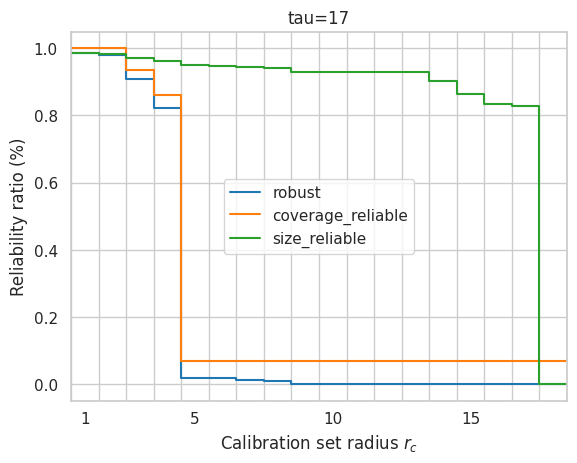

In [11]:
xticklabels = np.arange(1,21, dtype=object)
xticklabels = [str(i)  if i in [1,5,10,15] else "" for i in xticklabels]
xticks = np.arange(0, 19, step=1).astype(int)
xlabel = "Calibration set radius $r_c$"
ylabel = "Reliability ratio (%)"
title = f"tau={conformal_result[2]}"

step_plot(certificates, xticks, xticklabels, xlabel, ylabel, title)